In [463]:
import matplotlib.pyplot as plt
import numpy as np
from mst_algorithm import MST
from mst_graphs_local import NetworkXGraph
import networkx as nx
import random
import time
from enum import Enum


In [464]:
class GraphType(Enum):
    RANDOM = 'ramdom_graph'
    EXPANDER = 'expander_graph'
    COMPLETE = 'complete_graph'
    CYCLE = 'cycle_graph'
    
class WeightDistribution(Enum):
    RANDOM = 'random_weights'
    EXPONENTIAL = 'exponantial_weights'
    NORMAL = 'normal_weights'

default_size = 1000
default_degree = 4
default_max_weight = 100
default_max_read = 50
default_graph_type = GraphType.RANDOM
default_weight_distribution = WeightDistribution.RANDOM

def print_constants(custom_size, degree, max_read,max_weight, graph_type, weight_distribution):
    output = "Size: "+str(custom_size)+"\n"+"Degree: "+str(degree)+"\n"+"Max Weight: "+str(max_weight)+"\n"+"Max Read: "+str(max_read)+"\n"+"Graph Type: "+str(graph_type)+"\n"+"Weight Distribution: "+str(weight_distribution)+"\n"
    print(output)

In [465]:
#Random NetworkX graph

def random_graph(degree,size):
    graph = nx.generators.random_regular_graph(degree, size)
    return graph
    
#Expanders NetworkX Graph

def expander_graph(size):
    graph = nx.generators.paley_graph(size)
    return graph


# Complete graph

def complete_graph(size):
    graph = nx.generators.complete_graph(size)
    return graph

# Cycle graph

def cycle_graph(size):
    graph = nx.generators.cycle_graph(size)
    return graph


In [466]:
def assign_random_edge_weights(graph, max_weight):
    for (u, v) in graph.edges():
        graph.edges[u, v]['weight'] = random.randint(1, max_weight)
    return graph

def assign_exponential_edge_weights(graph,custom_scale=1):
    for (u, v) in graph.edges():
        graph.edges[u, v]['weight'] = round(np.random.exponential(scale=custom_scale)+1)
    return graph

def assign_normal_edge_weights(graph, max_weight):
    for (u, v) in graph.edges():
        graph.edges[u, v]['weight'] = round(np.random.normal(loc=(max_weight/2)))
    return graph

In [467]:
def kruskall_comparison(custom_size=default_size, degree=default_degree, max_read=default_max_read, max_weight=default_max_weight,graph_type=default_graph_type,weight_distribution=default_weight_distribution):
    
    if max_read >= custom_size:
        raise Exception("Please reduce default_max_read or increase node size!")
    
    print("Create graph with the following constants:")
    print_constants(custom_size, degree, max_read,max_weight,graph_type,weight_distribution)
    
    #Chose here different graph options from above
    graph = None
    
    if graph_type is GraphType.RANDOM:
        graph = random_graph(degree,custom_size)
    elif graph_type is GraphType.EXPANDER:
        graph = expander_graph(custom_size)
    elif graph_type is GraphType.COMPLETE:
        graph = complete_graph(custom_size)
    elif graph_type is GraphType.CYCLE:
        graph = complete_graph(custom_size)
                        
    #Chose here different weight sampling options from above
    if weight_distribution is WeightDistribution.RANDOM:
        graph = assign_random_edge_weights(graph, max_weight)
    elif weight_distribution is WeightDistribution.EXPONENTIAL:
        graph = assign_exponential_edge_weights(graph)
    elif weight_distribution is WeightDistribution.NORMAL:
        graph = assign_normal_edge_weights(graph,max_weight)
        
    #Our algorithm
    our_start_time = time.time()
    approx = MST(
        NetworkXGraph(graph, custom_size, max_weight, max_read)
    ).approx_weight()
    our_runtime = time.time() - our_start_time
    #print("Our Runtime: "+str(our_runtime))
    #print("Our MST weight approx. for random graph:", approx,"\n")
    
    #NetworkX Kruskall Algorithm
    kruskall_start_time = time.time()
    mst=nx.minimum_spanning_tree(graph)
    kruskall_time = time.time()-kruskall_start_time
    #print("NetworkX Kruskall runtime: "+str(kruskall_time))

    gt_w = sum(graph.edges[e]["weight"] for e in mst.edges)
    #print("ground truth weight", gt_w)

    ratio = max(gt_w, approx) / min(gt_w, approx)
    err = 100 * (ratio - 1)
    #print("error %", err)
    
    results = {
        "our_time" : our_runtime,
        "kuskrall_time" : kruskall_time,
        "groundtruth" : gt_w,
        "approximation" : approx,
        "error" : err
    }
    
    print("Results",results,"\n")
    return results

In [468]:
# Test case that increasing node size with options to customize parameters

def increasing_runtime_performance(start,stop,increment,degree=default_degree,max_read=default_max_read,max_weight=default_max_weight,graph_type=default_graph_type,weight_distribution=default_weight_distribution):
    sizes = []
    o_times = []
    k_times = []
    results = []
    for size in range(start,stop,increment):
        try:
            result = kruskall_comparison(custom_size=size, degree=degree, max_read=max_read, max_weight=max_weight,graph_type=graph_type,weight_distribution=weight_distribution)
        except Exception as e:
            print(e)
        sizes.append(size)
        o_times.append(result["our_time"])
        k_times.append(result["kuskrall_time"])
        results.append(result)
    plt.figure()
    plt.plot(sizes,o_times)
    plt.plot(sizes,k_times)
    plt.xlabel("Nodes")
    plt.ylabel("Time")
    plt.show()
    return results

Create graph with the following constants:
Size: 100
Degree: 5
Max Weight: 5
Max Read: 30
Graph Type: GraphType.RANDOM
Weight Distribution: WeightDistribution.NORMAL

Results {'our_time': 0.7332069873809814, 'kuskrall_time': 0.0012989044189453125, 'groundtruth': 170, 'approximation': 99, 'error': 71.71717171717171} 



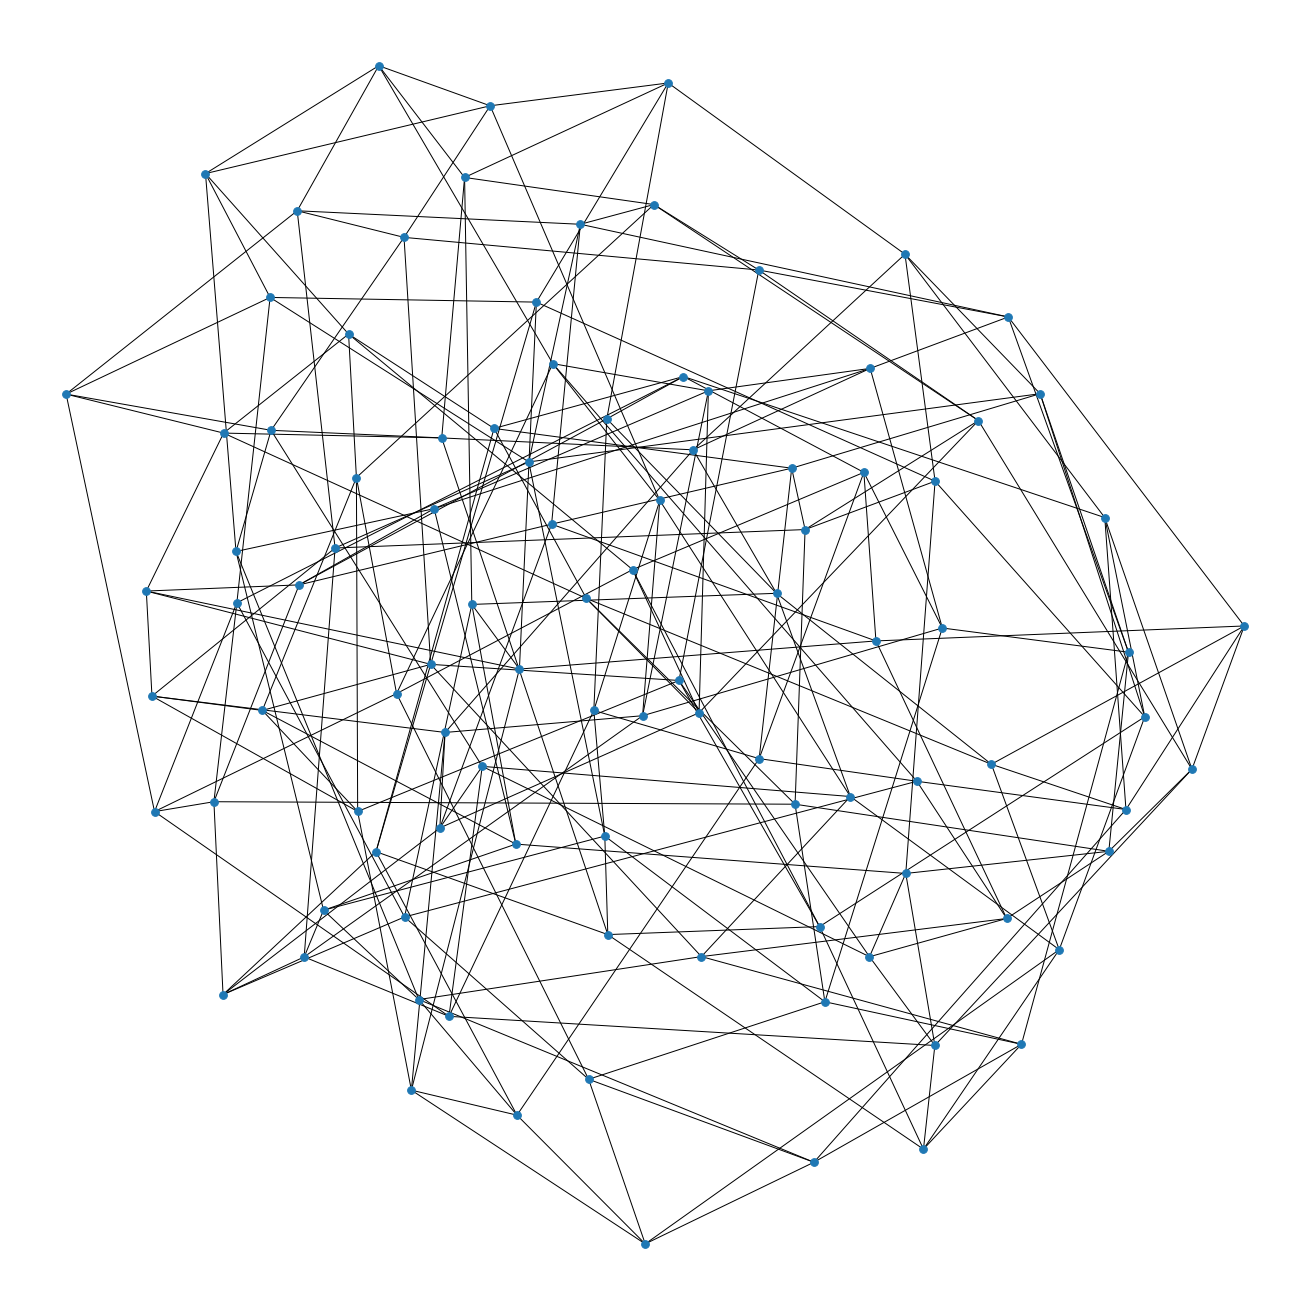

In [469]:
#Different test options

#Single kruskall comparison with default values
#result_single_default = kruskall_comparison()

#Skruskall comparison with custom parameters
result_single_custom = kruskall_comparison(custom_size=100, degree=5, max_read=30, max_weight=5,graph_type=GraphType.RANDOM,weight_distribution=WeightDistribution.NORMAL)

#Increase node size with custom settings
#result_increment_custom = increasing_runtime_performance(start=100,stop=1000,increment=10,graph_type=GraphType.RANDOM,weight_distribution=WeightDistribution.RANDOM)

